In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In this notebook, we will build a Convolutional Neural Network (CNN) for identifying text in an image.

<br/>
   <img src='../images/2_layer_conv.png' height=80% width=70% />
<br/>


A typical convolutional neural network (CNN) consists of:
- [Convolution Layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)<br/>
  &nbsp;&nbsp;&nbsp;&nbsp;  It can be thought of as stack of filters. It is the core component of any CNN.
- [Pooling Layers](https://pytorch.org/docs/stable/nn.html#pooling-layers)
  &nbsp;&nbsp;&nbsp;&nbsp;  It is quite common to insert a pooling layer just after a convolution layer in a CNN. It is usually used to bring down the spatial size of the representation learned through a convolution layer.
- [Fully Connected Layers](https://pytorch.org/docs/stable/nn.html#linear-layers)<br/>
  &nbsp;&nbsp;&nbsp;&nbsp;  It usually applies a linear tranformation to the input data. We usually use one or more fully-connected-linear layers as the final few layers in a CNN to produce a fixed size output.
  
While the core components of any CNN is $(i)$ Convolution Layers, $(ii)$ Pooling Layers, and $(iii)$ Fully Connected Layers, any convolutional-neural-network (CNN) can comprise of various other layers, like:<br/>
- [Padding Layers](https://pytorch.org/docs/stable/nn.html#padding-layers)
- [Normalization Layers](https://pytorch.org/docs/stable/nn.html#normalization-layers)
- [Dropout Layers](https://pytorch.org/docs/stable/nn.html#dropout-layers)
- [Pixel-Shuffle and Upsample Layers](https://pytorch.org/docs/stable/nn.html#vision-layers)
- [Channel-Shuffle Layers](https://pytorch.org/docs/stable/nn.html#shuffle-layers)

**[CNN Demo](https://cs231n.github.io/convolutional-networks/)**


Here we'll use the FMNIST dataset which consists of greyscale fashion images. 
Each image is 28x28 pixels, you can see a sample imgae in the below

<br/>
    <img src='../images/fashion-mnist-sprite.png' width="500" />
<br/>

First we will download FMNIST dataset, which is provided through [``torchvision``](https://pytorch.org/vision/stable/index.html) package.

### Loading FMNIST dataset into train-val-test set

In [2]:
import torchvision.transforms as transforms 
import torchvision.datasets as datasets

We usually use various random transformation for training-dataset to get various augmentations.

However, for test-dataset we do not use any random transformations.

Random transformations are provided through [``torchvision.transforms``](https://pytorch.org/vision/stable/transforms.html) package.

**train-test-transform**

In [3]:
# Define a transform to normalize the data
train_transform = transforms.Compose([transforms.RandomResizedCrop((28, 28)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [4]:
train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=train_transform)

# val-dataset refers to the same dataset as train-dataset, however, while validating the model's performance
# we do not use any random-transformation
val_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=test_transform)

test_dataset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=test_transform)

**Separating train-set into train & validation set**
- Let's set validation set size as 20%, therefore, we will be using 80% of training set for training 
    the neural network
- Validating a model while training w.r.t a validation-set can help us from overfitting
- Validation-set works as an alternative to the actual test-set, as it is assumed that while training 
    we do not have any access to the test-set 

In [5]:
train_set_size = len(train_dataset)
print('train-set-size: {}'.format(train_set_size))

train-set-size: 60000


In [6]:
all_indices = list(range(train_set_size))
print('len(all_indices): '.format(len(all_indices)))

np.random.shuffle(all_indices)

val_size = int(0.2 * len(all_indices))
train_size = len(all_indices) - val_size
print('val-size: {} train-size: {}'.format(val_size, train_size))

val_indices = all_indices[:val_size]
train_indices = all_indices[val_size:]

print('len(train_indices): {} len(val_indices): {}'.format(len(train_indices), len(val_indices)))

len(all_indices): 
val-size: 12000 train-size: 48000
len(train_indices): 48000 len(val_indices): 12000


In [7]:
from torch.utils.data import SubsetRandomSampler

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                           sampler=SubsetRandomSampler(train_indices), num_workers=4, 
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                        sampler=SubsetRandomSampler(val_indices), num_workers=4,
                                        pin_memory=True)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True,
                                          num_workers=4, pin_memory=True)

In [9]:
train_batch, _ = next(iter(train_loader))
val_batch, _ = next(iter(val_loader))
test_batch, _ = next(iter(test_loader))

In [10]:
import torchvision

train_grid_img = torchvision.utils.make_grid(train_batch, nrow=8)
val_grid_img = torchvision.utils.make_grid(val_batch, nrow=8)
test_grid_img = torchvision.utils.make_grid(test_batch, nrow=8)

#### Display a batch of training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


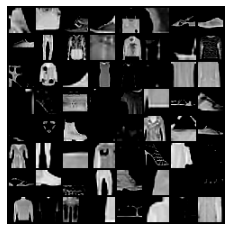

In [11]:
plt.imshow(train_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### Display a batch of validation data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


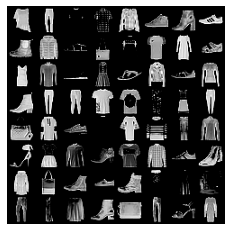

In [12]:
plt.imshow(val_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### Display a batch of test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


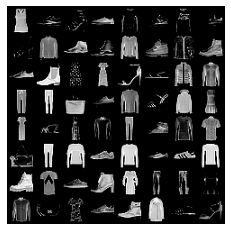

In [13]:
plt.imshow(test_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [14]:
!python --version

Python 3.7.7


## Define CNN Architecture (Type - 1)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet1(nn.Module):
    def __init__(self, in_channels: int=1, num_classes: int=10) -> None:
        super(LeNet1, self).__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1   = nn.Linear(in_features=16*4*4, out_features=120)
        self.fc2   = nn.Linear(in_features=120, out_features=84)
        self.fc3   = nn.Linear(in_features=84, out_features=self.num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [16]:
model = LeNet1()
print(model)

data = torch.randn(10, 1, 28, 28)
with torch.no_grad():
    output = model(data)

print('data.shape: {} output.shape: {}'.format(data.size(), output.size()))

LeNet1(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
data.shape: torch.Size([10, 1, 28, 28]) output.shape: torch.Size([10, 10])


## Define CNN Architecture (Type - 2)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet2(nn.Module):
    def __init__(self, in_channels: int=1, num_classes: int=10, rate: float=0.4) -> None:
        super(LeNet2, self).__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes
        self.rate = rate

        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1   = nn.Linear(in_features=16*4*4, out_features=120)
        self.dropout1 = nn.Dropout(p=self.rate)
        self.fc2   = nn.Linear(in_features=120, out_features=84)
        self.dropout2 = nn.Dropout(p=self.rate)
        self.fc3   = nn.Linear(in_features=84, out_features=self.num_classes)
        self.dropout3 = nn.Dropout(p=self.rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.dropout1(out)
        out = F.relu(self.fc1(out))
        out = self.dropout2(out)
        out = F.relu(self.fc2(out))
        out = self.dropout3(out)
        out = self.fc3(out)
        return out

In [18]:
model = LeNet2()
print(model)

data = torch.randn(10, 1, 28, 28)
with torch.no_grad():
    output = model(data)

print('data.shape: {} output.shape: {}'.format(data.size(), output.size()))

LeNet2(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
)
data.shape: torch.Size([10, 1, 28, 28]) output.shape: torch.Size([10, 10])


## CNN training

In [19]:
import torch
import torch.nn as nn
from torch.nn import DataParallel
import time
import torch.optim as optim

from typing import Tuple, Any, List

def trainCls(model: nn.Module, train_loader: torch.utils.data.DataLoader, 
             val_loader: torch.utils.data.DataLoader, lr: float=0.1, epochs: int=100, 
             momentum: float=0.9, weight_decay: float=5e-4, 
             checkpoint: str='./checkpoint') -> Tuple[nn.Module, List, List, List, List]:
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device: {}'.format(device))
    
    model.to(device) # loading model to device

    if torch.cuda.device_count() > 1:
        if not isinstance(model, DataParallel):
            model = DataParallel(model) # if more that one gpu is available,
                                        # then wrap model with DataParallel,
                                        # so that it can be trained on multiple gpus
    
    model.to(device) # load model to device

    criterion = nn.CrossEntropyLoss() # loss-function for classification
    
    # optimizer is used to optime the model parameters while doing back-propagation
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    start = time.time()
    best_acc = 0.0
    
    trainLoss_, valLoss_ = list(), list()
    trainAcc_, valAcc_ = list(), list()
    
    start_epoch = 0

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            model.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            train_acc += predicted.eq(target).sum().item()
        
        train_loss, train_acc = train_loss/len(train_loader.sampler), train_acc/len(train_loader.sampler)
        trainLoss_.append(train_loss)
        trainAcc_.append(train_acc)

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        for _, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            val_acc += predicted.eq(target).sum().item()
        
        val_loss, val_acc = val_loss/len(val_loader.sampler), val_acc/len(val_loader.sampler)
        valLoss_.append(val_loss)
        valAcc_.append(val_acc)

        if val_acc > best_acc:
            print('Epoch: {} val accuracy improved: {:0.4f} ==> {:0.4f}'.format(epoch+1, best_acc, val_acc))
            best_acc = val_acc

            try:
                state_dict = model.state_dict()
            except:
                state_dict = model.module.state_dict()

            torch.save(state_dict, checkpoint)

        print('Epoch: [{}/{}] train_acc: {:0.4f} val_acc: {:0.4f} train_loss: {:0.4f} val_loss: {:0.4f}'.format(epoch+1, epochs, train_acc, val_acc, train_loss, val_loss))

    total_time = time.time() - start
    print('time: {:0.0f}m {:0.0f}s'.format((total_time//60), (total_time%60)))
    
    # loading model's best saved weight
    try:
        model.load_state_dict(torch.load(checkpoint, map_location=device))
    except:
        model.module.load_state_dict(torch.load(checkpoint, map_location=device))

    return model, trainLoss_, valLoss_, trainAcc_, valAcc_

## CNN evaluation

In [20]:
def testCls(model: nn.Module, test_loader: torch.utils.data.DataLoader, 
            checkpoint: str) -> Tuple[nn.Module, float, float]:
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device: {}'.format(device))
    
    model.to(device) # loading model to device

    if torch.cuda.device_count() > 1:
        if not isinstance(model, DataParallel):
            model = DataParallel(model) # if more that one gpu is available,
                                        # then wrap model with DataParallel,
                                        # so that it can be trained on multiple gpus
    
    model.to(device) # load model to device

    criterion = nn.CrossEntropyLoss() # loss-function for classification
    
    # loading model's saved weight
    try:
        model.load_state_dict(torch.load(checkpoint, map_location=device))
    except:
        model.module.load_state_dict(torch.load(checkpoint, map_location=device))

    model.eval()
    
    test_loss, test_acc = 0.0, 0.0
    for _, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        data = data.to(memory_format=torch.contiguous_format)

        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        test_acc += predicted.eq(target).sum().item()

    test_loss, test_acc = test_loss/len(test_loader.sampler), test_acc/len(test_loader.sampler)

    print('test_loss: {:0.4f} \t test_acc: {:0.4f}'.format(test_loss, test_acc))

    return model, test_loss, test_acc

### Training CNN (Type - 1) with Pytorch

In [21]:
model = LeNet1()
print(model, '\n\n')

LeNet1(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
) 




In [22]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, checkpoint='cnn_type_1_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.5041
Epoch: [1/100] train_acc: 0.2355 val_acc: 0.5041 train_loss: 2.1095 val_loss: 1.3227
Epoch: 2 val accuracy improved: 0.5041 ==> 0.6716
Epoch: [2/100] train_acc: 0.4799 val_acc: 0.6716 train_loss: 1.4327 val_loss: 0.8717
Epoch: [3/100] train_acc: 0.5455 val_acc: 0.6642 train_loss: 1.2290 val_loss: 0.8451
Epoch: 4 val accuracy improved: 0.6716 ==> 0.6893
Epoch: [4/100] train_acc: 0.5822 val_acc: 0.6893 train_loss: 1.1258 val_loss: 0.7965
Epoch: 5 val accuracy improved: 0.6893 ==> 0.7104
Epoch: [5/100] train_acc: 0.5985 val_acc: 0.7104 train_loss: 1.0770 val_loss: 0.7331
Epoch: 6 val accuracy improved: 0.7104 ==> 0.7422
Epoch: [6/100] train_acc: 0.6145 val_acc: 0.7422 train_loss: 1.0348 val_loss: 0.6874
Epoch: [7/100] train_acc: 0.6212 val_acc: 0.7352 train_loss: 1.0140 val_loss: 0.6705
Epoch: [8/100] train_acc: 0.6353 val_acc: 0.7262 train_loss: 0.9806 val_loss: 0.7350
Epoch: 9 val accuracy improved: 0.7422 ==> 0.7673
Epoch

Epoch: [82/100] train_acc: 0.7542 val_acc: 0.8642 train_loss: 0.6674 val_loss: 0.3691
Epoch: [83/100] train_acc: 0.7502 val_acc: 0.8636 train_loss: 0.6766 val_loss: 0.3757
Epoch: [84/100] train_acc: 0.7510 val_acc: 0.8662 train_loss: 0.6761 val_loss: 0.3618
Epoch: [85/100] train_acc: 0.7558 val_acc: 0.8453 train_loss: 0.6618 val_loss: 0.4085
Epoch: [86/100] train_acc: 0.7514 val_acc: 0.8592 train_loss: 0.6745 val_loss: 0.3797
Epoch: 87 val accuracy improved: 0.8718 ==> 0.8722
Epoch: [87/100] train_acc: 0.7532 val_acc: 0.8722 train_loss: 0.6684 val_loss: 0.3432
Epoch: [88/100] train_acc: 0.7526 val_acc: 0.8652 train_loss: 0.6690 val_loss: 0.3594
Epoch: [89/100] train_acc: 0.7540 val_acc: 0.8722 train_loss: 0.6639 val_loss: 0.3500
Epoch: [90/100] train_acc: 0.7535 val_acc: 0.8628 train_loss: 0.6680 val_loss: 0.3619
Epoch: [91/100] train_acc: 0.7537 val_acc: 0.8303 train_loss: 0.6626 val_loss: 0.4476
Epoch: [92/100] train_acc: 0.7549 val_acc: 0.8713 train_loss: 0.6598 val_loss: 0.3486
Epo

In [23]:
model, test_loss, test_acc = testCls(model, test_loader, checkpoint='cnn_type_1_best_model.pth')

device: cuda:0
test_loss: 0.3585 	 test_acc: 0.8676


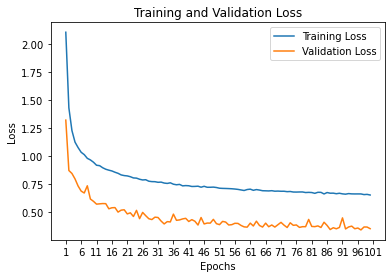

In [24]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

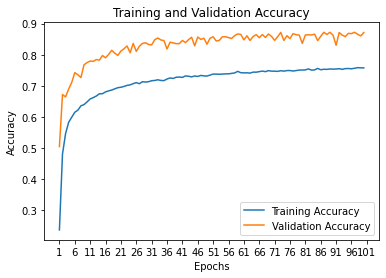

In [25]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

### Training CNN (Type - 2) with Pytorch

In [26]:
model = LeNet2()
print(model, '\n\n')

LeNet2(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
) 




In [27]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, checkpoint='cnn_type_2_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.3960
Epoch: [1/100] train_acc: 0.1586 val_acc: 0.3960 train_loss: 2.2346 val_loss: 1.9320
Epoch: 2 val accuracy improved: 0.3960 ==> 0.4950
Epoch: [2/100] train_acc: 0.3115 val_acc: 0.4950 train_loss: 1.8374 val_loss: 1.2636
Epoch: 3 val accuracy improved: 0.4950 ==> 0.6223
Epoch: [3/100] train_acc: 0.4029 val_acc: 0.6223 train_loss: 1.5882 val_loss: 1.0651
Epoch: 4 val accuracy improved: 0.6223 ==> 0.6638
Epoch: [4/100] train_acc: 0.4509 val_acc: 0.6638 train_loss: 1.4765 val_loss: 0.9325
Epoch: 5 val accuracy improved: 0.6638 ==> 0.6720
Epoch: [5/100] train_acc: 0.4825 val_acc: 0.6720 train_loss: 1.3962 val_loss: 0.8666
Epoch: 6 val accuracy improved: 0.6720 ==> 0.6855
Epoch: [6/100] train_acc: 0.5086 val_acc: 0.6855 train_loss: 1.3405 val_loss: 0.8302
Epoch: 7 val accuracy improved: 0.6855 ==> 0.7192
Epoch: [7/100] train_acc: 0.5294 val_acc: 0.7192 train_loss: 1.2906 val_loss: 0.7720
Epoch: [8/100] train_acc: 0.5403 val_acc

Epoch: [79/100] train_acc: 0.6691 val_acc: 0.8223 train_loss: 0.9267 val_loss: 0.4688
Epoch: [80/100] train_acc: 0.6664 val_acc: 0.8277 train_loss: 0.9314 val_loss: 0.4621
Epoch: [81/100] train_acc: 0.6646 val_acc: 0.8160 train_loss: 0.9364 val_loss: 0.4834
Epoch: [82/100] train_acc: 0.6674 val_acc: 0.8263 train_loss: 0.9277 val_loss: 0.4734
Epoch: [83/100] train_acc: 0.6657 val_acc: 0.8223 train_loss: 0.9338 val_loss: 0.4794
Epoch: [84/100] train_acc: 0.6667 val_acc: 0.8260 train_loss: 0.9304 val_loss: 0.4668
Epoch: [85/100] train_acc: 0.6670 val_acc: 0.8280 train_loss: 0.9294 val_loss: 0.4636
Epoch: [86/100] train_acc: 0.6636 val_acc: 0.8266 train_loss: 0.9323 val_loss: 0.4610
Epoch: [87/100] train_acc: 0.6669 val_acc: 0.8303 train_loss: 0.9270 val_loss: 0.4623
Epoch: [88/100] train_acc: 0.6712 val_acc: 0.8293 train_loss: 0.9271 val_loss: 0.4621
Epoch: [89/100] train_acc: 0.6687 val_acc: 0.8302 train_loss: 0.9272 val_loss: 0.4605
Epoch: [90/100] train_acc: 0.6706 val_acc: 0.8289 trai

In [28]:
model, test_loss, test_acc = testCls(model, test_loader, checkpoint='cnn_type_2_best_model.pth')

device: cuda:0
test_loss: 0.4655 	 test_acc: 0.8262


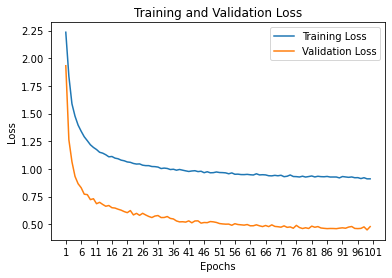

In [29]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

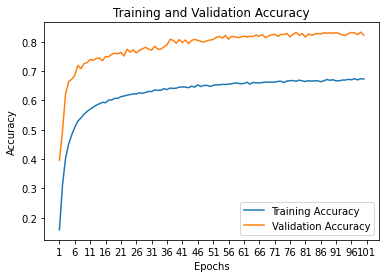

In [30]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()